# How to Run HellaSwag with Generative Models (Hugging Face Transformers)
Based on: 
- https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py
- https://github.com/shinwookim/research/blob/eabdf92eb534596a5cb65d106aca18a7221d9e93/notebooks/mmlu.ipynb

In [1]:
import json
import os
import time
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 1.52 MiB/s, done.


In [3]:
choices = ["A", "B", "C", "D"]

In [4]:
!git clone https://github.com/rowanz/hellaswag

Cloning into 'hellaswag'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 45 (delta 0), reused 2 (delta 0), pack-reused 41
Unpacking objects: 100% (45/45), 17.69 MiB | 7.31 MiB/s, done.


In [5]:
DATA_DIR = "/kaggle/working/hellaswag/data/hellaswag"

In [6]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [7]:
import os
import argparse
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from mersenne import mersenne_rng
import pandas as pd
from tqdm import tqdm
import numpy as np  # Import numpy for array slicing

def generate_shift(model, prompt, vocab_size, n, m, key):
    rng = mersenne_rng(key)
    xi = torch.tensor([rng.rand() for _ in range(n*vocab_size)]).view(n, vocab_size)
    shift = torch.randint(n, (1,))

    inputs = prompt.to(model.device)
    attn = torch.ones_like(inputs)
    past = None
    for i in range(m):
        with torch.no_grad():
            if past:
                output = model(inputs[:, -1:], past_key_values=past, attention_mask=attn)
            else:
                output = model(inputs)

        probs = torch.nn.functional.softmax(output.logits[:, -1, :vocab_size], dim=-1).cpu()
        token = exp_sampling(probs, xi[(shift+i)%n, :]).to(model.device)
        inputs = torch.cat([inputs, token], dim=-1)

        past = output.past_key_values
        attn = torch.cat([attn, attn.new_ones((attn.shape[0], 1))], dim=-1)

    return inputs.detach().cpu()

def exp_sampling(probs, u):
    return torch.argmax(u ** (1/probs), axis=1).unsqueeze(-1)




In [8]:
# Helper Functions: Largely unchanged from https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py

def compute_metric(output_filename):
    df = pd.read_csv(output_filename)

  # Extract pred_answers and gold_answers columns
    pred_answers = df['pred_answers'].tolist()
    gold_answers = df['gold_answers'].tolist()
    total_acc = 0
    total_num = 0
    acc = 0

    for pred, gold in zip(pred_answers, gold_answers):
        if pred == gold: acc += 1
    print("Accuracy for HellaSwag: %.4f" % ( acc/len(gold_answers)))

def prepare_input(tokenizer, prompts):
    input_tokens = tokenizer.batch_encode_plus(prompts, return_tensors="pt", padding=True)
    input_tokens = {k:input_tokens[k] for k in input_tokens if k in ["input_ids", "attention_mask"]}
    for t in input_tokens:
        if torch.is_tensor(input_tokens[t]):
            input_tokens[t] = input_tokens[t].to('cuda')

    return input_tokens

def batch_split(prompts, batch_num):
    batch_prompts = []
    mini_batch = []
    for prompt in prompts:
        mini_batch.append(prompt)
        if len(mini_batch) == batch_num:
            batch_prompts.append(mini_batch)
            mini_batch = []
    if len(mini_batch) != 0:
        batch_prompts.append(mini_batch)
    return batch_prompts

def batch_infer(model, tokenizer, prompts):
    batch_size = 8
    answers = []
    for batch_input in tqdm(batch_split(prompts, batch_size)):
        encode_inputs = prepare_input(tokenizer, batch_input)
        with torch.no_grad():
            outputs = model.generate(**encode_inputs, max_new_tokens=1, pad_token_id=tokenizer.pad_token_id)
            answers.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    answers = [answer[-1] for answer in answers]
    return answers

def infer_with_watermark(model, tokenizer, prompts):
    batch_size = 1
    answers = []
    for prompt in tqdm(prompts, total = len(prompts)):
        tokens = tokenizer.encode(prompt, return_tensors='pt', truncation=True, max_length=2048)
        with torch.no_grad():
            watermarked_tokens = generate_shift(model,tokens,len(tokenizer),256,1,42)[0]
            watermarked_text = tokenizer.decode(watermarked_tokens, skip_special_tokens=True)
            answers.append(watermarked_text)
    answers = [answer[-1] for answer in answers]
    return answers

In [9]:
def format_example(df, idx, include_answer=True):
    """
    Formats a single example from the DataFrame into a prompt string.

    Args:
      df: The pandas DataFrame containing data.
      idx: The index of the example to format.
      include_answer: Whether to include the answer in the prompt (default: True).

    Returns:
      A string containing the formatted prompt.
    """
    prompt = df.loc[idx, 'ctx']  # Use loc for cleaner indexing
    k = len(df.loc[idx, "endings"])  # Calculate number of ending options
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df["endings"][idx][j])
    prompt += "\nCorrect choice: "
    if include_answer:
        prompt += " {}".format(chr(ord('A') + df.loc[idx, 'label']))  # Access label using loc
#     else: 
#         prompt +=' '
    prompt += "\n\n"
    return prompt

def gen_prompt(train_df, subject, k=-1):
    """
    Generates a prompt string containing multiple choice questions from the DataFrame.

    Args:
      train_df: The pandas DataFrame containing training data.
      subject: The subject of the prompt (optional).
      k: The number of examples to include (default: all).

    Returns:
      A string containing the formatted prompt.
    """
    prompt = "Solve the following multiple choice question and select the choice (A, B, C, or D ONLY) that best completes the passage. Repeating the same choice will be penalized as well as any blank answers.\nBCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCD\n\n"
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt


# import pandas as pd

# data = {
#   "ctx": "Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles.",
#   "endings": [[", the man adds wax to the windshield and cuts it.", ", a person boards a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled.", ", the man puts on a christmas coat, knitted with netting.", ", the man puts on a christmas coat, knitted with netting."]],
#   "label": 3
# }

# df = pd.DataFrame(data)

# # Test format_example function
# example_prompt = format_example(df, 0)
# print(example_prompt)

# # Test gen_prompt function
# full_prompt = gen_prompt(df, "Sample Subject")
# print(full_prompt)

In [10]:
def load(checkpoint, model_type):
    n_gpus = torch.cuda.device_count()
    
    model = AutoModelForCausalLM.from_pretrained(checkpoint).cuda()
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding_side='left')      
    model.eval()
    return model, tokenizer

In [11]:
import pandas as pd

def jsonl_to_dataframe(filepath):
    """
    Reads a JSONL file and converts it to a pandas DataFrame.

    Args:
      filepath (str): Path to the JSONL file.

    Returns:
      pandas.DataFrame: DataFrame containing the extracted data.
    """
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            json_data = json.loads(line.strip())  # Load JSON data inside the loop
            data.append({"ctx": json_data["ctx"], "endings": json_data["endings"], "label": json_data["label"]})
    return pd.DataFrame(data)

# filepath = "/kaggle/working/hellaswag/data/hellaswag_train.jsonl"  # Replace with your actual file path
# df = jsonl_to_dataframe(filepath)

# print(df.head(1))  # Print the first few rows of the DataFrame


In [12]:
import pandas as pd


def select_5_samples(data):
    """
    Selects 5 examples from a dataframe, ensuring 1 from each label (0-3) and an extra random one

    Args:
      data: A pandas dataframe containing 'text' and 'label' columns

    Returns:
      A pandas dataframe containing 5 rows, 1 from each label and an extra random one
    """
#     data = data[data['label'] != 0]

    label_counts = data['label'].value_counts()
#     print(label_counts)
    min_samples_per_label = 1
    samples_to_select = min_samples_per_label * len(label_counts) + 1

    # Check if enough data is available
    if samples_to_select > len(data):
        raise ValueError("Dataframe has less samples than required number to select")

    # Efficiently select one sample from each label using sample
    selected_data = pd.concat([data[data["label"] == label].sample(1, random_state=41) for label in label_counts.index])
#     print(selected_data)
    # Select remaining samples randomly from the entire DataFrame
    remaining_samples = samples_to_select - len(selected_data)
#     print(remaining_samples)
    selected_data = pd.concat([selected_data, data.sample(remaining_samples, random_state=41)])
    # Return the first 5 rows (or all if less than 5 were selected)
    return selected_data.reset_index(drop=True)

if __name__ == "__main__":
  # Assuming you have a function to create your DataFrame from JSONL (not shown here)
    data = jsonl_to_dataframe(DATA_DIR + "_train.jsonl")
    result = select_5_samples(data.copy())
    print(result)


                                                 ctx  \
0  Two girls prepares to jump rope, then the girl...   
1  From the roof we see the street where a car is...   
2  [header] How to know if you're sleep deprived ...   
3  [header] How to get rid of a cold sore fast [t...   
4  They seem to be having a great time as the cam...   

                                             endings  label  
0  [, the ladies hong walks to arrange a jump rop...      1  
1  [puts a latch on the hole and attach a wire to...      3  
2  [Disruptions in the sleep cycle have been stro...      0  
3  [There are many antiviral treatment options fo...      2  
4  [then cuts, showing the camel come to a stop b...      0  


In [13]:
import re

def modify_text(text):
    """
    Modifies the text by replacing any occurrence of bracketed words with the same word followed by a colon (":")

    Args:
      text: The text to be modified.

    Returns:
      The modified text.
    """
    pattern = r"\[([^]]+)\]"  # Matches any word inside square brackets
    return re.sub(pattern, r"\1:", text)  # Replaces matched word with itself + colon

# text = """
# [header] How to know if you're sleep deprived [title] Be aware of decreased cognitive function.
# """

# modified_text = modify_text(text)

# print(modified_text)


In [14]:
def main(ckpt_dir: str, param_size: str, model_type: str):
    
    run_results = {}
    output_filename = 'run_results_%s_%sb.csv' % (model_type, param_size)
    evaluation_filename = 'evaluation_%s_%sb.csv' % (model_type, param_size)  # New filename

    model, tokenizer = load(ckpt_dir, model_type)
    start_time = time.time()

    print('Evaluating ...')
    records = []
    
    train_all_df = jsonl_to_dataframe(DATA_DIR + "_train.jsonl")
    train_df = select_5_samples(train_all_df).sample(1, random_state=3).reset_index(drop=True)
#     train_df = train_all_df.sample(2, random_state=21).reset_index(drop=True)
#     print(train_df)
    val_df = jsonl_to_dataframe(DATA_DIR + "_val.jsonl")
    val_df = val_df.iloc[6300:7000].reset_index(drop=True)
#     print(val_df)
    for i in range(val_df.shape[0]):
        # get prompt and make sure it fits
        k = 5
#         print(val_df)
        prompt_end = format_example(val_df, i, include_answer=False)
        train_prompt = gen_prompt(train_df, k)
        prompt = modify_text(train_prompt + prompt_end)
        if i==1:
            print(prompt)
        while len(tokenizer.tokenize(prompt)) + 1> 2048: # bos token
            prompt_split = prompt.split("\n\n")
            prompt_split.pop(1)
            prompt = '\n\n'.join(prompt_split)
        label = val_df.iloc[i, val_df.shape[1]-1]
        records.append({
          'prompt': prompt,
          'answer': chr(ord('A') + label),  # Convert label to answer char (A, B, C, ...)
          'predicted_answer': None  # Add field for predicted answer
        })
    pred_answers = infer_with_watermark(model, tokenizer, [record['prompt'] for record in records])
    for i, record in enumerate(records):
        record['predicted_answer'] = pred_answers[i]  # Assign predicted answer
    gold_answers = [record['answer'] for record in records]
#     print(gold_answers)
#     print(pred_answers)
    run_results = {'pred_answers': pred_answers, 'gold_answers': gold_answers}
    
    # Create DataFrame from dictionary
    df = pd.DataFrame(run_results)
    # Save DataFrame to CSV file
    df.to_csv(output_filename, index=False)    
    # Create record df
    record_df = pd.DataFrame(records)
    record_df.to_csv(evaluation_filename, index=False)
    compute_metric(output_filename)
    end_time = time.time()
    print("total run time %.2f" % (end_time - start_time))
    del model
    del tokenizer
    return (end_time - start_time)

In [15]:
model = "facebook/opt-350m"
rslt = dict()


rslt[model] =  main(model, model.replace("facebook/opt-", ""), "OPT")



config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Evaluating ...
Solve the following multiple choice question and select the choice (A, B, C, or D ONLY) that best completes the passage. Repeating the same choice will be penalized as well as any blank answers.
BCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCDABCD

header: How to get rid of a cold sore fast title: Apply an antiviral cream. step: Although a cold sore cannot be " cured ", medications and treatments can ease your symptoms and speed up the natural healing process. Probably the quickest and easiest way to treat a cold sore is way a treatment you can get from your pharmacy or drug store without a prescription from your doctor.
A. There are many antiviral treatment options for cold sores. If you need to stop fatty habits before your cold sore begins, talk to your doctor or pharmacist to see if this is an option for you.
B. substeps: Antiviral cream can ease

100%|██████████| 700/700 [8:36:43<00:00, 44.29s/it]

Accuracy for HellaSwag: 0.1814
total run time 31005.61


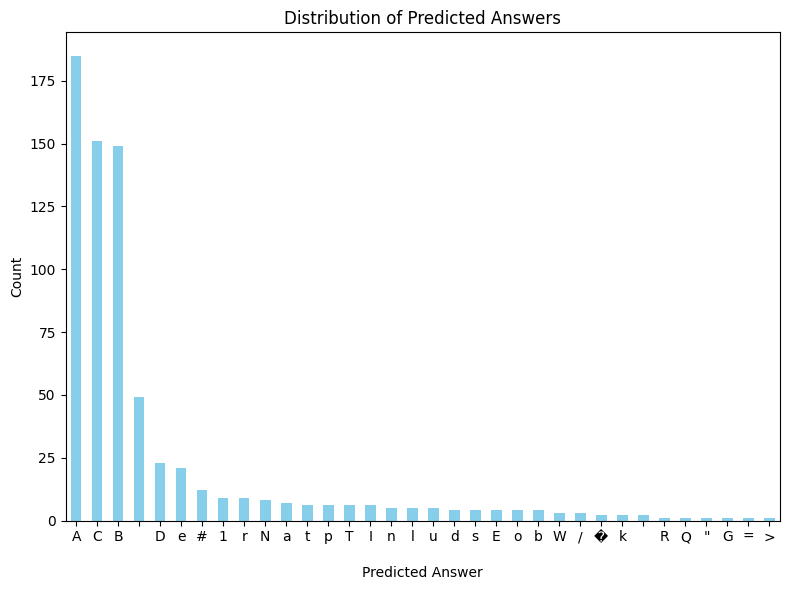

In [16]:
import matplotlib.pyplot as plt
def analyze_predictions(filename):
    """
    Analyzes predicted answers from a CSV file and creates a bar chart.

    Args:
      filename: Path to the CSV file containing "predicted_answer" column.
    """
    # Read data from CSV file
    df = pd.read_csv(filename)

    # Count occurrences of each predicted answer
    answer_counts = df['predicted_answer'].value_counts()

    # Create bar chart
    plt.figure(figsize=(8, 6))
    answer_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Predicted Answer')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Answers')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming filename is set)
filename = "/kaggle/working/watermark/demo/evaluation_OPT_350mb.csv"
analyze_predictions(filename)

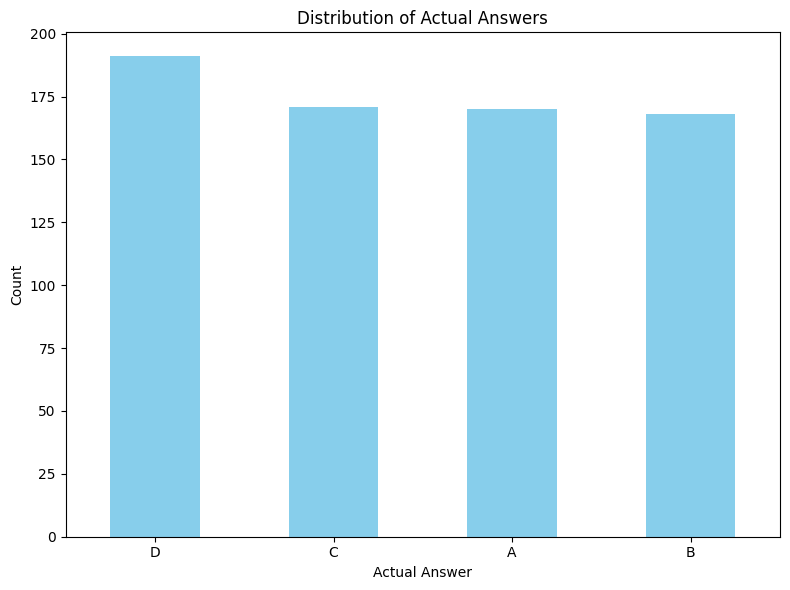

In [17]:
import matplotlib.pyplot as plt
def analyze_actual(filename):
    """
    Analyzes predicted answers from a CSV file and creates a bar chart.

    Args:
      filename: Path to the CSV file containing "predicted_answer" column.
    """
    # Read data from CSV file
    df = pd.read_csv(filename)

    # Count occurrences of each predicted answer
    answer_counts = df['answer'].value_counts()

    # Create bar chart
    plt.figure(figsize=(8, 6))
    answer_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Actual Answer')
    plt.ylabel('Count')
    plt.title('Distribution of Actual Answers')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming filename is set)
filename = "/kaggle/working/watermark/demo/evaluation_OPT_350mb.csv"
analyze_actual(filename)